## Objective

In [ ]:
# Investigate Results With precipition



Dependencies

c:\Python38_64\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


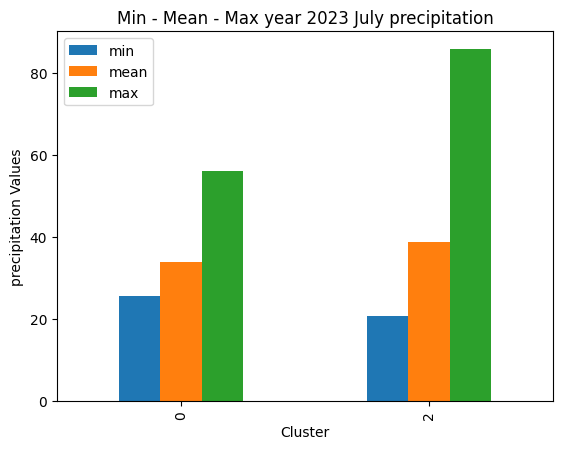

In [26]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import xarray as xr
from fuzzywuzzy import process


#Directories
general_directory = '/Users/Roy/Desktop/PaletteSkills/Stream-3__AI_ML_Doc/Palette_Cohort_7-main/Final-project/data/'
## Reading canolla File
Canolla_weighted_avg_year_rm = pd.read_csv(general_directory+'Canolla_weighted_avg_year_rm.csv')

## Reading Precipitition file for July 2023

Precipitation_MB_July2023 = pd.read_csv(general_directory+'july_2023_precip_sum.csv')


# # Reading Shapely
ShaplyGeoJason_Data = 'Shapely_GeoJason_Data/MUNICIPALITY.geojson'
gdf_rm = gpd.read_file(general_directory+ShaplyGeoJason_Data, engine="pyogrio")
gdf_rm=gdf_rm.rename(columns={'MUNI_LIST_NAME': 'RM'})

## GIS Visualization
def match_rms(rm, choices, limit=2):
    """Fuzzy match an RM name to the closest ones from a list of choices."""
    results = process.extract(rm, choices, limit=limit)
    return results[0]  # Return the best match

# List of RMs in df_yield_raw_3 to match against
yield_rms = Canolla_weighted_avg_year_rm['RM'].unique()

# Apply fuzzy matching for RMs in gdf_rm that are not found in df_yield_raw_3
gdf_rm['Matched_RM'] = gdf_rm['RM'].apply(lambda x: match_rms(x, yield_rms))

# Now check the matched results and scores
gdf_rm['Match_Score'] = gdf_rm['Matched_RM'].apply(lambda x: x[1])  # Get the match score
gdf_rm['Matched_RM'] = gdf_rm['Matched_RM'].apply(lambda x: x[0])   # Get the actual matched RM name

gdf_rm = gdf_rm.loc[:,['RM', 'geometry', 'Matched_RM', 'Match_Score']]

# Filter out 100% similarity
gdf_rm_filtered_Matched100 = gdf_rm[gdf_rm['Match_Score'] == 100]

gdf_rm_filtered_Matched95 = gdf_rm[(
                                (gdf_rm['Match_Score']>=95) &\
                                ((gdf_rm['Match_Score']<100))
                                )]

gdf_rm_filtered_Matched95['Matched_RM'] = gdf_rm_filtered_Matched95['RM']

gdf_rm_filtered = pd.concat([gdf_rm_filtered_Matched100,gdf_rm_filtered_Matched95])

yield_rms_Mod = gdf_rm_filtered['RM'].unique()

gdf_rm_filtered = gdf_rm_filtered.loc[:,['RM', 'geometry']]
gdf_rm_filtered = gpd.GeoDataFrame(gdf_rm_filtered)

# Apply fuzzy matching for RMs in gdf_rm that are not found in df_yield_raw_3
gdf_rm_filtered['Matched_RM'] = gdf_rm_filtered['RM'].apply(lambda x: match_rms(x, yield_rms_Mod))

# Now check the matched results and scores
gdf_rm_filtered['Match_Score'] = gdf_rm_filtered['Matched_RM'].apply(lambda x: x[1])  # Get the match score
gdf_rm_filtered['Matched_RM'] = gdf_rm_filtered['Matched_RM'].apply(lambda x: x[0])   # Get the actual matched RM name


# Filter out 100% similarity
gdf_rm_filtered_Matched100 = gdf_rm_filtered[gdf_rm_filtered['Match_Score'] == 100]
gdf_rm_filtered_MatchedNot100 = gdf_rm_filtered[gdf_rm_filtered['Match_Score'] < 100]

# Merge using the fuzzy matched RMs
merged_df_fuzz_Canolla = pd.merge(Canolla_weighted_avg_year_rm, gdf_rm_filtered, left_on='RM', right_on='Matched_RM', how='left')


merged_df_fuzz_Canolla = merged_df_fuzz_Canolla.loc[:,['Matched_RM', 'Match_Score',
       'Year', 'Crop','Weighted_Avg_Yield','Yield_Diff', 'Cluster', 'geometry']]

merged_df_fuzz_Canolla = merged_df_fuzz_Canolla[merged_df_fuzz_Canolla['Match_Score'] == 100]

merged_df_fuzz_Canolla = merged_df_fuzz_Canolla[merged_df_fuzz_Canolla['Year'] == 2023]



merged_df_Preciption2023 = pd.merge(merged_df_fuzz_Canolla, Precipitation_MB_July2023, left_on=['Matched_RM', 'Year'], right_on=['Matched_RM', 'Year'], how='left')


gdf_rm_yield_Canolla = merged_df_Preciption2023.reset_index(drop=True)
gdf_rm_yield_Canolla = gpd.GeoDataFrame(gdf_rm_yield_Canolla)

grouped_df = gdf_rm_yield_Canolla.groupby('Cluster')['precip'].agg(['min', 'mean','max']).reset_index()

# Plot as bar chart
grouped_df.plot(
    x='Cluster', 
    kind='bar', 
    stacked=False,
    title='Min - Mean - Max year 2023 July precipitation',
    xlabel='Cluster', 
    ylabel='precipitation Values'
)
plt.show()





# Aggregate by 'Cluster', taking the mean of 'precip' (or another suitable operation)
aggregated_gdf = gdf_rm_yield_Canolla.groupby(['Year', 'Matched_RM', 'Cluster']).agg({
    'precip': 'mean',    # Use mean or another appropriate aggregation
    'geometry': 'first',  # Select the first geometry in each cluster (or use 'unary_union' for complex shapes)
    'Weighted_Avg_Yield':'mean'
}).reset_index()

aggregated_gdf = gpd.GeoDataFrame(aggregated_gdf)
# Assign colors for each cluster
cluster_RM_Repcolor = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8", "#33FFA5"]


# Plot with explore
aggregated_gdf.explore(
    column='Cluster',  # Column to color by
    categorical=True,
    cmap=cluster_RM_Repcolor,
    legend=True,
    tooltip=['Matched_RM', 'Weighted_Avg_Yield','Cluster', 'precip']  # Show cluster and precipitation data on hover
)


